In [158]:
import sys
from datetime import datetime
sys.path.append('../../Scripts')
from preprocess_daily import DailyPreprocessor
self = DailyPreprocessor()

# 1. 데이터 준비
self.load_data()

self.make_match1()
self.make_match2()
self.make_match3()
self.make_match4()
self.make_match5()

1. 데이터를 로드합니다.
1-1. 네트워크가 로드되었습니다.
1-2. 테이블들이 로드되었습니다.
1-3. 네트워크의 모든 clean state requirement들을 체크했습니다.
1-4. 테이블들의 무결성 검사를 완료했습니다.


이동류정보 불러오는 중: 100%|██████████| 17280/17280 [00:13<00:00, 1269.15it/s]


In [159]:
# self.node2inter = dict(zip(self.inter_node['node_id'], self.inter_node['inter_no']))

# child_ids = self.inter_node[self.inter_node.inter_type=='child'].node_id.unique()
# ch2pa = {} # child to parent
# for child_id in child_ids:
#     parent_no = self.inter_node[self.inter_node.node_id==child_id].inter_no.iloc[0]
#     sub_inter_node = self.inter_node[self.inter_node.inter_no==parent_no]
#     ch2pa[child_id] = sub_inter_node[sub_inter_node.inter_type=='parent'].iloc[0].node_id
# directions = ['북', '북동', '동', '남동', '남', '남서', '서', '북서'] # 정북기준 시계방향으로 8방향

# # 각 uturn node에 대하여 (inc_edge_id, out_edge_id) 부여
# cmatches = []
# for _, row in self.uturn.iterrows():
#     child_id = row.child_id
#     parent_id = row.parent_id
#     direction = row.direction
#     condition = row.condition
#     inc_edge_id = row.inc_edge
#     out_edge_id = row.out_edge
#     # match5에서 parent_id에 해당하는 행들을 가져옴
#     cmatch = self.match5.copy()[self.match5.node_id==parent_id] # match dataframe for a child node
#     cmatch = cmatch.sort_values(by=['phase_no', 'ring_type']).reset_index(drop=True)
#     cmatch['node_id'] = child_id
#     cmatch[['inc_edge', 'out_edge']] = np.nan

#     # condition 별로 inc_dire, out_dire_A, out_dire_B를 정함
#     ind = directions.index(direction)
#     if condition == "좌회전시":
#         inc_dire = direction
#         out_dire_A = out_dire_B = directions[(ind + 2) % len(directions)]
#     elif condition == "보행신호시":
#         inc_dire = directions[(ind + 2) % len(directions)]
#         out_dire_A = directions[(ind - 2) % len(directions)]
#         out_dire_B = directions[(ind - 2) % len(directions)]
#     print(child_id, ((cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_A)).any())
#     # (inc_dire, out_dire_A, out_dire_B) 별로 inc_edge_id, out_edge_id를 정함
#     cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_A), ['inc_edge', 'out_edge']] = [inc_edge_id, out_edge_id]
#     cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_B), ['inc_edge', 'out_edge']] = [inc_edge_id, out_edge_id]
#     if condition == '보행신호시':
#         # 이동류번호가 17(보행신호)이면서 유턴노드방향으로 가는 신호가 없으면 (inc_edge_id, out_edge_id)를 부여한다.
#         cmatch.loc[(cmatch.move_no==17) & (cmatch.out_dir!=direction), ['inc_edge', 'out_edge']] = [inc_edge_id, out_edge_id]
#     # 유턴신호의 이동류번호를 19로 부여한다.
#     cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_A), 'move_no'] = 19
#     cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_B), 'move_no'] = 19
#     cmatches.append(cmatch)

# # 각 coordination node에 대하여 (inc_edge_id, out_edge_id) 부여
# self.coord['inter_no'] = self.coord['parent_id'].map(self.node2inter)
# self.coord = self.coord.rename(columns={'child_id':'node_id'})
# self.coord[['inc_dir', 'out_dir', 'inc_angle','out_angle']] = np.nan
# self.coord['move_no'] = 20
# self.coord = self.coord[['inter_no', 'phase_no', 'ring_type', 'move_no', 'inc_dir', 'out_dir', 'inc_angle','out_angle', 'inc_edge', 'out_edge', 'node_id']]

# # display(coord)
# cmatches = pd.concat(cmatches)
# self.match6 = pd.concat([self.match5, cmatches, self.coord]).drop_duplicates().sort_values(by=['inter_no', 'node_id', 'phase_no', 'ring_type'])
# # self.match6.to_csv(os.path.join(self.path_intermediates, 'match6.csv'))

splits 딕셔너리 다시 만들기

In [160]:
import numpy as np
row = self.plan.iloc[0]
# print(row)
inter_no = row.inter_no
start_hour = row.start_hour
start_minute = row.start_minute
cycle = row.cycle

dura_A = np.array(row[[f'dura_A{j}' for j in range(1, 9)]])
dura_B = np.array(row[[f'dura_B{j}' for j in range(1, 9)]])

print(dura_A)
print(dura_B)

cums_A = dura_A.cumsum()
cums_B = dura_B.cumsum()

combined_row = np.unique(np.concatenate((cums_A,cums_B)))
detailed_durations = np.concatenate(([combined_row[0]], np.diff(combined_row)))

print(detailed_durations)

split = {}
ja = 0
jb = 0
for k in range(len(detailed_durations)):
    dura_A[ja] -= detailed_durations[k]
    dura_B[jb] -= detailed_durations[k]
    split[(ja+1, jb+1)] = k+1
    if dura_A[ja] == 0:
        ja += 1
    if dura_B[jb] == 0:
        jb += 1
print(split)
print({(1, 1): 1, (2, 2): 2, (3, 3): 3, (3, 4): 4, (4, 4): 5})

[37 39 55 29  0  0  0  0]
[37 39 25 59  0  0  0  0]
[37 39 25 30 29]
{(1, 1): 1, (2, 2): 2, (3, 3): 3, (3, 4): 4, (4, 4): 5}
{(1, 1): 1, (2, 2): 2, (3, 3): 3, (3, 4): 4, (4, 4): 5}


In [161]:
import numpy as np
row = self.plan.iloc[0]
inter_no = row.inter_no
start_hour = row.start_hour
start_minute = row.start_minute
cycle = row.cycle

dura_A = row[[f'dura_A{j}' for j in range(1, 9)]]
dura_B = row[[f'dura_B{j}' for j in range(1, 9)]]

print(np.array(dura_A))
print(np.array(dura_B))

cums_A = row[[f'dura_A{j}' for j in range(1,9)]].cumsum()
cums_B = row[[f'dura_B{j}' for j in range(1,9)]].cumsum()

print(np.array(cums_A))
print(np.array(cums_B))

detailed_cums = []
combined_row = np.unique(np.concatenate((cums_A,cums_B)))
print(combined_row)
detailed_durations = np.concatenate(([combined_row[0]], np.diff(combined_row)))

print(detailed_durations)

duration_dict = {}
# 두 시리즈의 길이가 같다고 가정합니다.
for i in range(len(dura_A)):
    # A와 B의 현시시간이 같은 경우
    if dura_A[i] == dura_B[i]:
        duration_dict[(i+1, i+1)] = dura_A[i]
    # A와 B의 현시시간이 다른 경우
    else:
        duration_dict[(i+1, i+1)] = min(dura_A[i], dura_B[i])
        duration_dict[(i+1, i+2)] = max(dura_A[i], dura_B[i])

print(duration_dict)
# cums_A = row[[f'dura_A{j}' for j in range(1,9)]].cumsum()
# cums_B = row[[f'dura_B{j}' for j in range(1,9)]].cumsum()
# print(cums_A)
# print(cums_B)
# detailed_cums = []
# combined_row = np.unique(np.concatenate((cums_A,cums_B)))
# print(combined_row)
# detailed_durations = np.concatenate(([combined_row[0]], np.diff(combined_row)))
# print(detailed_durations)

[37 39 55 29  0  0  0  0]
[37 39 25 59  0  0  0  0]
[ 37  76 131 160 160 160 160 160]
[ 37  76 101 160 160 160 160 160]
[ 37  76 101 131 160]
[37 39 25 30 29]
{(1, 1): 37, (2, 2): 39, (3, 3): 25, (3, 4): 55, (4, 4): 29, (4, 5): 59, (5, 5): 0, (6, 6): 0, (7, 7): 0, (8, 8): 0}


In [162]:
import time
start_time = time.time()

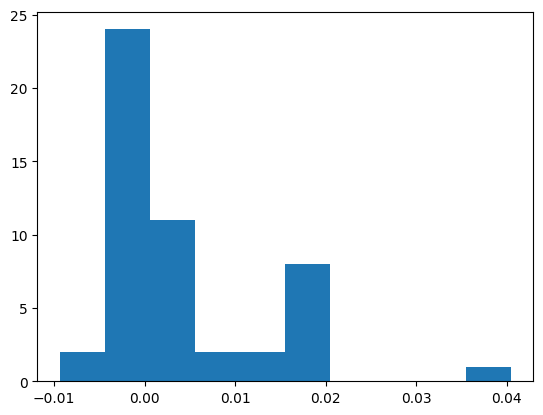

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

n_nums = 1000
n_rows = 100000
# Creating a large DataFrame with thousands of rows
np.random.seed(0)  # Seed for reproducibility
df = pd.DataFrame({
    'foo': np.random.choice(n_nums, n_rows),  # 1000 unique values repeated over 10000 rows
    'bar': np.random.rand(n_rows),
    'baz': np.random.choice(['bonjour','merci','bon nuit', 'enchante'], n_rows),
    'fruit': np.random.choice(['fraise','banana','orange', 'raisin'], n_rows)
})
# display(df)

n_iterations = 50
improved_times = []
for i in range(n_iterations):
    # print(i)
    selected_number = np.random.choice(n_nums)
    # Original method: filtering without setting an index
    time0 = time.time()
    df1 = df[df.foo == selected_number]
    # display(df1)
    time1 = time.time()

    # Improved method: setting 'foo' as index and then using .loc[]
    df2 = df.set_index('foo').loc[selected_number]
    # display(df2.reset_index(drop=True))
    time2 = time.time()

    # Times
    elapsed_time_1 = time1 - time0 # 기존 방법의 소요시간
    elapsed_time_2 = time2 - time1 # 새 방법의 소요시간
    improved_time = elapsed_time_2 - elapsed_time_1 # 이 값이 작을수록 개선된다.
    
    improved_times.append(improved_time)
# print(improved_times)
plt.hist(improved_times)
plt.show()

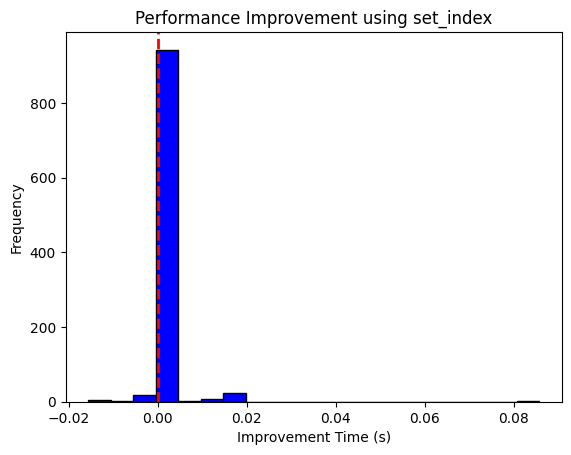

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

n_nums = 1000
n_rows = 100000
# Creating a large DataFrame with thousands of rows
np.random.seed(0)  # Seed for reproducibility
df = pd.DataFrame({
    'foo': np.random.choice(n_nums, n_rows),  # 1000 unique values repeated over 100000 rows
    'bar': np.random.rand(n_rows),
    'baz': np.random.choice(['bonjour','merci','bon nuit', 'enchante'], n_rows),
    'fruit': np.random.choice(['fraise','banana','orange', 'raisin'], n_rows)
})

# Set 'foo' as index once before the loop
df.set_index('foo', inplace=True)

n_iterations = 1000
improved_times = []
for i in range(n_iterations):
    selected_number = np.random.choice(n_nums)

    # Original method: filtering without setting an index
    # Since we have already set the index, we need to reset it without inplace modification
    df_reset = df.reset_index()
    time0 = time.time()
    df1 = df_reset[df_reset.foo == selected_number]
    time1 = time.time()

    # Improved method: using .loc[] with 'foo' already set as index
    time2 = time.time()
    df2 = df.loc[selected_number]
    time3 = time.time()

    # Times
    elapsed_time_1 = time1 - time0  # Original method time
    elapsed_time_2 = time3 - time2  # Improved method time
    improved_time = elapsed_time_1 - elapsed_time_2  # The lower this value, the better the improvement
    
    improved_times.append(improved_time)

# Plotting the histogram of improved times
plt.hist(improved_times, bins=20, color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2)  # Add a vertical line at x=0 for reference
plt.xlabel('Improvement Time (s)')
plt.ylabel('Frequency')
plt.title('Performance Improvement using set_index')
plt.show()


In [ ]:
# Let's create a new MWE where `set_index` and using `.loc[]` shows better performance compared to the basic slicing method.

# Seed for reproducibility
np.random.seed(0)

# Constants for the DataFrame
n_nums = 10  # Reduce the number of unique values to increase the likelihood of matches and make the index more effective
n_rows = 100000

# Create a large DataFrame with thousands of rows
df = pd.DataFrame({
    'foo': np.random.choice(n_nums, n_rows),  # 10 unique values repeated over 100000 rows
    'bar': np.random.rand(n_rows),
})

# Original method: Measure the time taken for filtering without setting an index
time0 = time.time()
df1 = df[df.foo == 5]  # Choose a number that is guaranteed to be in 'foo'
time1 = time.time()
original_time = time1 - time0

# Improved method: Set 'foo' as index and measure the time taken for filtering using .loc[]
df.set_index('foo', inplace=True)
time2 = time.time()
df2 = df.loc[5]  # Using .loc[] on the indexed DataFrame
time3 = time.time()
improved_time = time3 - time2

# Results
original_time, improved_time, original_time > improved_time


(0.0010004043579101562, 0.0010085105895996094, False)

In [ ]:
# To make the operations take longer, we can increase the size of the data and the complexity of the operation.

# Constants for the DataFrame
n_nums = 10
n_rows = 10000000  # Increase the number of rows to 10 million

# Create a large DataFrame with millions of rows
df = pd.DataFrame({
    'foo': np.random.choice(n_nums, n_rows),  # 10 unique values repeated over 10 million rows
    'bar': np.random.rand(n_rows),
})

# Measure the time for the original method without setting an index
time0 = time.time()
df1 = df[df.foo == 5]
time1 = time.time()
original_time = time1 - time0

# Measure the time for the improved method using set_index and .loc[]
df_indexed = df.set_index('foo')
time2 = time.time()
df2 = df_indexed.loc[5]
time3 = time.time()
improved_time = time3 - time2

# Results
original_time, improved_time, original_time > improved_time


(0.06691646575927734, 0.08325934410095215, False)

In [ ]:
import pandas as pd
import numpy as np
import time

# 데이터 생성
n = 1000000  # 데이터 포인트 수
df = pd.DataFrame({
    'foo': np.random.randint(0, 1000, size=n),  # 0에서 999 사이의 임의의 정수
    'bar': np.random.rand(n)  # 0과 1 사이의 임의의 부동 소수점 수
})

selected_number = 500  # 선택할 값

# 기본 슬라이싱
start_time = time.time()
df1 = df[df.foo == selected_number]
basic_slicing_time = time.time() - start_time

# set_index 및 .loc[] 사용
start_time = time.time()
df.set_index('foo', inplace=True)
df2 = df.loc[selected_number]
set_index_time = time.time() - start_time

# 성능 비교
print(f"기본 슬라이싱 시간: {basic_slicing_time:.6f}초")
print(f"set_index 및 .loc[] 사용 시간: {set_index_time:.6f}초")


기본 슬라이싱 시간: 0.003000초
set_index 및 .loc[] 사용 시간: 0.007908초


In [177]:
from generate_signals import SignalGenerator
self = SignalGenerator()

self.prepare_data()
self.process_history()
self.process_movement()
self.make_histids()

self.initialize_states()
self.assign_signals()
self.set_timepoints()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(self.Sigtable)

1. 데이터를 준비합니다.
1-1. 네트워크가 로드되었습니다.
1-2. 테이블들이 로드되었습니다.
2. 신호이력 테이블을 변환합니다.
3. 이동류정보 테이블을 변환합니다.
4. 통합 테이블을 생성합니다.
    node_id  start_unix  phase_sumo  duration                 state  \
98      c30  1704436790           0        38                rrrrrr   
99      c30  1704436790           1        39                GGGGGG   
100     c30  1704436790           2        43                GGGGGG   
101     c30  1704436790           3        50                GGGGGG   
164     c30  1704436960           0        38                rrrrrr   
165     c30  1704436960           1        39                GGGGGG   
166     c30  1704436960           2        43                GGGGGG   
167     c30  1704436960           3        50                GGGGGG   
228     c30  1704437130           0        38                rrrrrr   
229     c30  1704437130           1        39                GGGGGG   
230     c30  1704437130           2        43                GGGGGG   
231     c30  1704437130           

In [184]:
self.SIGTABLE = []
for _, group in self.Sigtable.groupby('node_id'):
    new_rows_list = []
    for i in range(1, len(group)):
        prev_row = group.iloc[i-1:i].copy()
        next_row = group.iloc[i:i+1].copy()
        new_rows = pd.concat([prev_row, prev_row, next_row]).reset_index(drop=True)
        new_rows.loc[0, 'phase_sumo'] = str(prev_row.phase_sumo.iloc[0]) + '_g'
        new_rows.loc[0, 'duration'] = new_rows.loc[0, 'duration'] - 5
        new_rows.loc[1, 'phase_sumo'] = str(prev_row.phase_sumo.iloc[0]) + '_y'
        new_rows.loc[1, 'duration'] = 4
        yellow_state = ''
        red_state = ''
        for a, b in zip(prev_row.state.iloc[0], next_row.state.iloc[0]):
            if a == 'G' and b == 'r':
                yellow_state += 'y'
                red_state += 'r'
            else:
                yellow_state += a
                red_state += a
        new_rows.loc[2, 'phase_sumo'] = str(next_row.phase_sumo.iloc[0]) + '__r'
        new_rows.loc[2, 'duration'] = 1
        new_rows.loc[1, 'state'] = yellow_state
        new_rows.loc[2, 'state'] = red_state
        new_rows_list.append(new_rows)
    next_row['phase_sumo'] = str(next_row.phase_sumo.iloc[0]) + '_g'
    next_row['duration'] -= 5
    new_rows_list.append(next_row)
    new_rows = pd.concat(new_rows_list)
    self.SIGTABLE.append(new_rows)
self.SIGTABLE = pd.concat(self.SIGTABLE).sort_values(by=['node_id', 'start_unix', 'phase_sumo']).reset_index(drop=True)
df1 = self.SIGTABLE

import pandas as pd

# 원본 데이터프레임: self.Sigtable
# 예제에서는 self.Sigtable이 이미 정의되어 있다고 가정합니다.

# 변환 과정을 최적화하기 위해 먼저 필요한 새로운 행을 계산하는 함수를 정의합니다.
def create_transformed_rows(group):
    transformed_rows = []
    for i in range(1, len(group)):
        prev_row = group.iloc[i-1]
        next_row = group.iloc[i]

        # 노란색과 빨간색 상태 계산
        yellow_state = ''.join(['y' if a == 'G' and b == 'r' else a for a, b in zip(prev_row['state'], next_row['state'])])
        red_state = ''.join(['r' if a == 'G' and b == 'r' else a for a, b in zip(prev_row['state'], next_row['state'])])

        # 새로운 행들을 생성
        new_rows = [
            {**prev_row, 'phase_sumo': f"{prev_row['phase_sumo']}_g", 'duration': prev_row['duration'] - 5},
            {**prev_row, 'phase_sumo': f"{prev_row['phase_sumo']}_y", 'duration': 4, 'state': yellow_state},
            {**next_row, 'phase_sumo': f"{next_row['phase_sumo']}_r", 'duration': 1, 'state': red_state}
        ]
        transformed_rows.extend(new_rows)

    # 마지막 행에 대한 처리
    last_row = group.iloc[-1].copy()
    last_row['phase_sumo'] = f"{last_row['phase_sumo']}_g"
    last_row['duration'] -= 5
    transformed_rows.append(last_row)

    return pd.DataFrame(transformed_rows)

# 각 그룹별로 변환 함수 적용
transformed_groups = [create_transformed_rows(group) for _, group in self.Sigtable.groupby('node_id')]

# 변환된 그룹들을 하나의 DataFrame으로 결합
self.SIGTABLE = pd.concat(transformed_groups).reset_index(drop=True)

# 결과 DataFrame 정렬
self.SIGTABLE = self.SIGTABLE.sort_values(by=['node_id', 'start_unix', 'phase_sumo']).reset_index(drop=True)


df2 = self.SIGTABLE

print(df1==df2)

     node_id  start_unix  phase_sumo  duration  state  start_dt
0       True        True        True      True   True      True
1       True        True        True      True   True      True
2       True        True       False     False  False      True
3       True        True       False     False  False      True
4       True        True        True      True   True      True
..       ...         ...         ...       ...    ...       ...
679     True        True       False     False   True      True
680     True        True       False     False   True      True
681     True        True        True      True   True      True
682     True        True       False     False   True      True
683     True        True       False     False   True      True

[684 rows x 6 columns]


In [216]:
# from generate_signals import SignalGenerator
# self = SignalGenerator()

# self.prepare_data()
# self.process_history()
# self.process_movement()
# self.merge_dfs()

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(self.histid)
#     display(self.match6)
# print(self.parent_ids)
# print(self.pa2ch)

new_histids = []
for parent_id in self.parent_ids:
    for child_id in self.pa2ch[parent_id]:
        new_histid = self.histid.copy()[self.histid.node_id==parent_id]
        new_histid[['inc_edge_A', 'out_edge_A', 'inc_edge_B', 'out_edge_B']] = np.nan
        for row in new_histid.itertuples(index=True):
            phas_A = row.phas_A
            phas_B = row.phas_B
            new_match = self.match6[self.match6.node_id==child_id]
            Arow = new_match[(new_match.phase_no==phas_A) & (new_match.ring_type=='A')]
            if not Arow[['inc_edge', 'out_edge']].isna().all().all():
                inc_edge = Arow.iloc[0].inc_edge
                out_edge = Arow.iloc[0].out_edge
                new_histid.loc[row.Index, ['inc_edge_A', 'out_edge_A']] = [inc_edge, out_edge]
            Brow = new_match[(new_match.phase_no==phas_B) & (new_match.ring_type=='B')]
            if not Brow[['inc_edge', 'out_edge']].isna().all().all():
                inc_edge = Brow.iloc[0].inc_edge
                out_edge = Brow.iloc[0].out_edge
                new_histid.loc[row.Index, ['inc_edge_B', 'out_edge_B']] = [inc_edge, out_edge]
            new_histid.loc[row.Index, 'node_id'] = child_id
        new_histids.append(new_histid)
new_histids = pd.concat(new_histids)
self.histids = pd.concat([self.histid.copy(), new_histids])
self.histids = self.histids.sort_values(by=['start_unix', 'node_id', 'phas_A', 'phas_B']).reset_index(drop=True)

# df1 = self.histids

# # self.match6에 대해 set_index를 사용해 인덱스 설정
# new_match_indexed = new_match.set_index(['phase_no', 'ring_type'])

# new_histids = []
# for parent_id in self.parent_ids:
#     for child_id in self.pa2ch[parent_id]:
#         new_histid = self.histid.copy()[self.histid.node_id==parent_id]
#         new_histid[['inc_edge_A', 'out_edge_A', 'inc_edge_B', 'out_edge_B']] = np.nan
#         for row in new_histid.itertuples(index=True):
#             phas_A = row.phas_A
#             phas_B = row.phas_B
#             new_match = self.match6[self.match6.node_id==child_id]
#             Arow = new_match_indexed.loc[(phas_A, 'A')]
#             if len(Arow.shape) == 1:
#                 Arow.inc_edge
#             else:
#                 Arow = Arow.reset_index(
#                    Arow.at[idx,'inc_edge'] 
#                 )
#             print(Arow)
#             if not Arow[['inc_edge', 'out_edge']].isna().all().all():
#                 inc_edge = Arow.inc_edge Arow['inc_edge']
#                 out_edge = Arow.out_edge
#                 new_histid.loc[row.Index, ['inc_edge_A', 'out_edge_A']] = [inc_edge, out_edge]
#             Brow = new_match_indexed.loc[(phas_B, 'B')]
#             if not Brow[['inc_edge', 'out_edge']].isna().all().all():
#                 inc_edge = Brow.inc_edge
#                 out_edge = Brow.out_edge
#                 new_histid.loc[row.Index, ['inc_edge_B', 'out_edge_B']] = [inc_edge, out_edge]
#             new_histid.loc[row.Index, 'node_id'] = child_id
#         new_histids.append(new_histid)
# new_histids = pd.concat(new_histids)
# self.histids = pd.concat([self.histid.copy(), new_histids])
# self.histids = self.histids.sort_values(by=['start_unix', 'node_id', 'phas_A', 'phas_B']).reset_index(drop=True)
# df2 = self.histids
# # 인덱스 재설정 전에 원래 상태로 되돌림
# self.match6.reset_index(inplace=True)
# display(df1)
# display(df2)
# df1 == df2

In [221]:
new_histids = []
match_set = self.match6.set_index(['phase_no','ring_type','node_id'])
for parent_id in self.parent_ids:
    for child_id in self.pa2ch[parent_id]:
        new_histid = self.histid.copy()[self.histid.node_id==parent_id]
        new_histid[['inc_edge_A', 'out_edge_A', 'inc_edge_B', 'out_edge_B']] = np.nan
        for row in new_histid.itertuples(index=True):
            phas_A = row.phas_A
            phas_B = row.phas_B
            Arow = match_set.loc[(phas_A,'A',child_id)]
            if (Arow.inc_edge == np.NaN)&(Arow.out_edge==np.NaN):
                inc_edge = Arow.iloc[0].inc_edge
                out_edge = Arow.iloc[0].out_edge
                new_histid.loc[row.Index, ['inc_edge_A', 'out_edge_A']] = [inc_edge, out_edge]
            Brow = match_set.loc[(phas_B,'B',child_id)]
            if (Brow.inc_edge == np.NaN)&(Brow.out_edge==np.NaN):
                inc_edge = Brow.iloc[0].inc_edge
                out_edge = Brow.iloc[0].out_edge
                new_histid.loc[row.Index, ['inc_edge_B', 'out_edge_B']] = [inc_edge, out_edge]
            new_histid.loc[row.Index, 'node_id'] = child_id
        new_histids.append(new_histid)
        # break
new_histids = pd.concat(new_histids)
self.histids = pd.concat([self.histid.copy(), new_histids])
self.histids = self.histids.sort_values(by=['start_unix', 'node_id', 'phas_A', 'phas_B']).reset_index(drop=True)

df1 = self.histids

print(Arow.inc_edge)

nan
